<h1>Experiment 1 - Standard LSTM Price Prediction<h1>

Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

Read in and prepare the data

In [2]:
df = pd.read_csv("AAPL.csv")

#Set date to correct format
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.set_index('Date', inplace=True)

#Use the adjusted close as the target variable
data = df[['Adjusted Close']]

# Scale the data using minmaxscaler to normalize ther data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

Create the sequence for the LSTM

In [3]:
def create_sequences(data, seq_length):
    x_data, y_data = [], []
    for i in range(seq_length, len(data)):
        x_data.append(data[i-seq_length:i, 0])
        y_data.append(data[i, 0])
    return np.array(x_data), np.array(y_data)

#Using the last 60 days to predict the next day
seq_length = 60 
x_data, y_data = create_sequences(scaled_data, seq_length)

Create training and test validation datasets

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Define a standard LSTM model and train it using 10 epochs, a batch size of 32 and learning rate of 0.001 and mean_squared error

In [5]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Predict the next day's price


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


C:\Users\James\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 8.2588e-05
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.3292e-06
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.5328e-06
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.1190e-06
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.6506e-06
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.3060e-06
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.8847e-06
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.9195e-06
Epoch 9/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.5775e-06
Epoch 10/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.4312e-06


Predict and plot

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


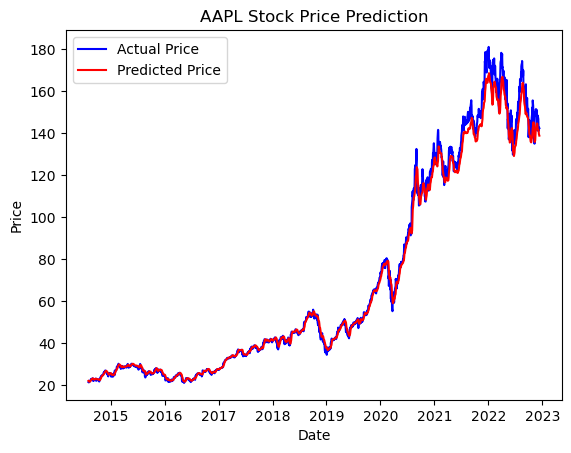

In [6]:
predicted_price = model.predict(x_test)

predicted_price = scaler.inverse_transform(predicted_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.plot(df.index[-len(y_test):], y_test_actual, color='blue', label='Actual Price')
plt.plot(df.index[-len(predicted_price):], predicted_price, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

<h1>Experiment 2 - Bidirectional LSTM Binary Classification<h1>

Import required libraries

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas_ta as ta

Read in data and create financial indicator features using pandas_ta

In [13]:

df = pd.read_csv("AAPL.csv")

df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.set_index('Date', inplace=True)

df['Return'] = df['Adjusted Close'].pct_change()

df.dropna(inplace=True)

df['Movement'] = (df['Return'] > 0).astype(int)

macd = ta.macd(df['Adjusted Close'])
df['MACD'] = macd['MACD_12_26_9']
df['MACD_signal'] = macd['MACDs_12_26_9']
df['MACD_hist'] = macd['MACDh_12_26_9']

stoch = ta.stoch(df['High'], df['Low'], df['Adjusted Close'])
df['Stoch_K'] = stoch['STOCHk_14_3_3']
df['Stoch_D'] = stoch['STOCHd_14_3_3']

df['RSI'] = ta.rsi(df['Adjusted Close'])

df.dropna(inplace=True)

# Prepare the input features
input_features = df[['Return', 'MACD', 'MACD_signal', 'Stoch_K', 'Stoch_D', 'RSI']]


Normalize and scale the data

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(input_features)

Create the sequences data structure for the bidirectional lstm

In [15]:
seq_length = 5  # Use 5 days of data to predict tomorrows movement


def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data) - 1):
        x.append(data[i-seq_length:i, :]) 
        y.append(df['Movement'].iloc[i + 1]) 
    return np.array(x), np.array(y)

x_data, y_data = create_sequences(scaled_data, seq_length)

Create the train, test and validation datasets

In [16]:
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=False)

Define the model bidirectional lstm architecture and call backs and determine the class weights so that the imbalances can be accouinted for in the model

In [17]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

model = Sequential()

# Add Bidirectional LSTM layers with Dropout and BatchNormalization
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Add a dense layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

C:\Users\James\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the model and malke predictions

In [19]:
# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=dict(enumerate(class_weights)),
    callbacks=callbacks
)

# Evaluate the model
predicted_probs = model.predict(x_test)
predicted_classes = (predicted_probs > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print("Model Accuracy: " +  str(accuracy * 100))


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4939 - loss: 0.8407 - val_accuracy: 0.4823 - val_loss: 0.7026 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5105 - loss: 0.7467 - val_accuracy: 0.4943 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5063 - loss: 0.7181 - val_accuracy: 0.4937 - val_loss: 0.7000 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4948 - loss: 0.7050 - val_accuracy: 0.5114 - val_loss: 0.7015 - learning_rate: 0.0010
Epoch 5/50
226/231 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5040 - loss: 0.7010
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5038 - loss: 0.7009 - val_accuracy: 0.4893 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5052 - loss: 0.6971 - v

Plot the results

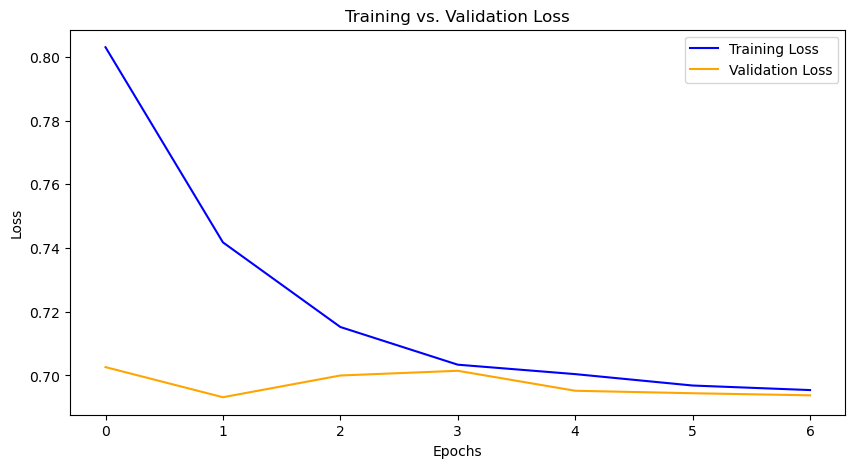

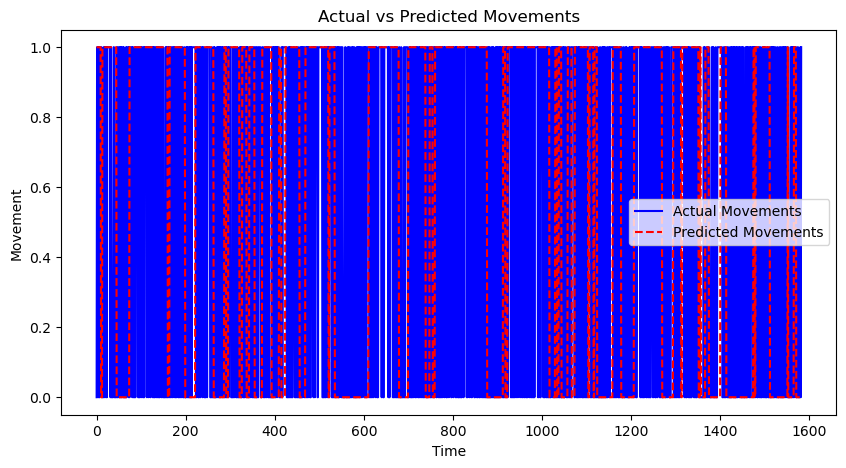

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Movements', color='blue')
plt.plot(predicted_classes, label='Predicted Movements', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Movement')
plt.title('Actual vs Predicted Movements')
plt.legend()
plt.show()